# What are the most demanded skills for the top 3 most popular data roles?

#### Methodology
1. Clean-up skill column
2. Calculate skill count based on `job_title_short`
3. Calculate skill percentage
4. Plot final findings

## Import Libraries and Data

In [1]:
# Importing Libraries
import ast
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt  

# Loading Data
df = pd.read_csv('../Project/data/job_postings_flat.csv')

# Data Cleanup
df['job_posted_date'] = pd.to_datetime(df['job_posted_date'])
df['job_skills'] = df['job_skills'].apply(lambda x: ast.literal_eval(x) if pd.notna(x) else x)

# Filter for 2025 data
df = df[df['job_posted_date'].dt.year == 2025]

## Filter Data for the United States

In [2]:
df_US = df[df['job_country'] == 'United States']

## Explode Skills

Since skills are stored as lists within each row, we need to explode them so each skill gets its own row. This lets us count and compare individual skills across job titles.

In [3]:
df_skills = df_US.explode('job_skills')

df_skills[['job_title', 'job_skills']]

,job_title,job_skills
1268007,Horticultural Data Analyst (Seasonal Project H...,excel
1268008,BIT Data Analyst,python
1268008,BIT Data Analyst,sql
1268009,Data Analyst - Healthcare,sql
1268009,Data Analyst - Healthcare,excel
...,...,...
1780664,Sr Data Scientist,sql
1780664,Sr Data Scientist,python
1780664,Sr Data Scientist,bigquery
1780664,Sr Data Scientist,jupyter


## Count Skills per Job Title

Group by skill and job title to get how often each skill appears per role.

In [4]:
# Group by job_skills and job_title_short and count the number of occurrences
df_skills_count = df_skills.groupby(['job_skills', 'job_title_short']).size()

# Name the count column as count
df_skills_count = df_skills_count.reset_index(name='skill_count')

# Sort the values by skill_count in descending order
df_skills_count.sort_values(by='skill_count', ascending=False, inplace=True)

df_skills_count

,job_skills,job_title_short,skill_count
1508,sql,Data Analyst,23291
1509,sql,Data Engineer,20603
1195,python,Data Engineer,20493
1196,python,Data Scientist,18207
438,excel,Data Analyst,18172
...,...,...,...
875,monday.com,Senior Data Analyst,1
14,airtable,Machine Learning Engineer,1
1839,workfront,Senior Data Scientist,1
1835,workfront,Cloud Engineer,1


## Create List of Top 3 Roles

#### Focus: Data Analysts, Data Engineers, and Data Scientists

Filter the job titles based on the most popular.

In [5]:
job_titles = df_skills_count['job_title_short'].unique().tolist()

job_titles = sorted(job_titles[:3])

job_titles

['Data Analyst', 'Data Engineer', 'Data Scientist']

## Plot Skill Counts

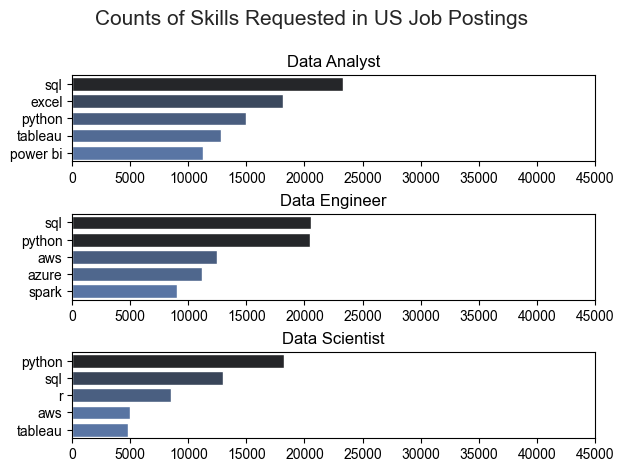

In [6]:
fig, ax = plt.subplots(len(job_titles), 1)

sns.set_theme(style='ticks')

for i, job_title in enumerate(job_titles):
    df_plot = df_skills_count[df_skills_count['job_title_short'] == job_title].head(5)[::-1]
    sns.barplot(data=df_plot, x='skill_count', y='job_skills', ax=ax[i], hue='skill_count', palette='dark:b_r')
    ax[i].set_title(job_title)
    ax[i].invert_yaxis()
    ax[i].set_ylabel('')
    ax[i].set_xlabel('')
    ax[i].get_legend().remove()
    ax[i].set_xlim(0, 45000) # make the scales the same

fig.suptitle('Counts of Skills Requested in US Job Postings', fontsize=15)
fig.tight_layout(h_pad=0.5) # fix the overlap
plt.show()

## Convert Counts to Percentages

Raw counts can be misleading since some roles have way more postings than others. Converting to percentages gives a fairer comparison across roles.

First, we need the total number of job postings per title to use as the denominator.

In [7]:
# Use original df to get the count of job titles
df_job_title_count = df_US['job_title_short'].value_counts().reset_index(name='jobs_total')

df_job_title_count

,job_title_short,jobs_total
0,Data Analyst,64305
1,Data Scientist,36832
2,Data Engineer,32785
3,Senior Data Analyst,11243
4,Business Analyst,9603
5,Senior Data Engineer,8720
6,Senior Data Scientist,7495
7,Machine Learning Engineer,5360
8,Software Engineer,4017
9,Cloud Engineer,1042


Now merge the skill counts with the total postings per role and calculate the percentage.

In [8]:
df_skills_perc = pd.merge(df_skills_count, df_job_title_count, on='job_title_short', how='left')

df_skills_perc['skill_percent'] = (df_skills_perc['skill_count'] / df_skills_perc['jobs_total']) * 100

df_skills_perc

,job_skills,job_title_short,skill_count,jobs_total,skill_percent
0,sql,Data Analyst,23291,64305,36.219579
1,sql,Data Engineer,20603,32785,62.842763
2,python,Data Engineer,20493,32785,62.507244
3,python,Data Scientist,18207,36832,49.432559
4,excel,Data Analyst,18172,64305,28.259078
...,...,...,...,...,...
1861,monday.com,Senior Data Analyst,1,11243,0.008894
1862,airtable,Machine Learning Engineer,1,5360,0.018657
1863,workfront,Senior Data Scientist,1,7495,0.013342
1864,workfront,Cloud Engineer,1,1042,0.095969


## Plot Percentage Count

Plot the top 5 skills for each role as horizontal bar charts with percentage labels.

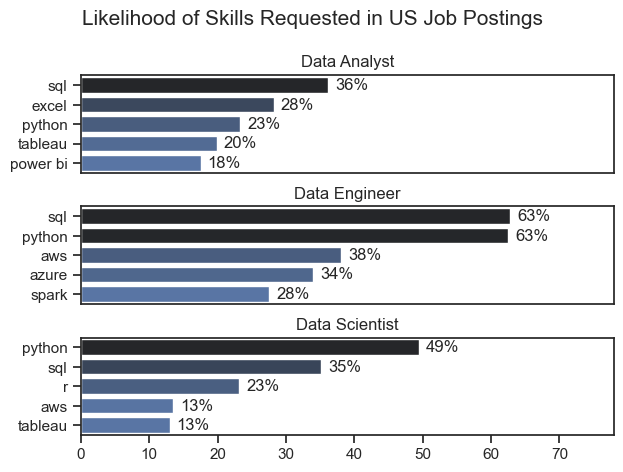

In [9]:
fig, ax = plt.subplots(len(job_titles), 1)


for i, job_title in enumerate(job_titles):
    df_plot = df_skills_perc[df_skills_perc['job_title_short'] == job_title].head(5)
    sns.barplot(data=df_plot, x='skill_percent', y='job_skills', ax=ax[i], hue='skill_count', palette='dark:b_r')
    ax[i].set_title(job_title)
    ax[i].set_ylabel('')
    ax[i].set_xlabel('')
    ax[i].get_legend().remove()
    ax[i].set_xlim(0, 78)
    # remove the x-axis tick labels for better readability
    if i != len(job_titles) - 1:
        ax[i].set_xticks([])

    # label the percentage on the bars
    for n, v in enumerate(df_plot['skill_percent']):
        ax[i].text(v + 1, n, f'{v:.0f}%', va='center')

fig.suptitle('Likelihood of Skills Requested in US Job Postings', fontsize=15)
fig.tight_layout(h_pad=.8)
plt.show()